In [3]:
# Packages for analysis
import pandas as pd
import numpy as np
from numpy import dtype
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from netCDF4 import Dataset,date2num,num2date
from datetime import datetime,timedelta
from wradlib.trafo import r_to_depth

# Packages for visuals
import matplotlib.pyplot as plt

# Allows charts to appear in the notebook
%matplotlib inline

import pyart
import numpy.ma as ma
import matplotlib.ticker as mticker
from matplotlib import colors as c
from matplotlib.colors import ListedColormap,BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.geodesic as cargeo
from shapely.geometry import Polygon
import os
import warnings
warnings.filterwarnings('ignore')

In [41]:
def QPE(Z,alpha=0.0365, beta=0.625):
    rr_data = alpha*np.ma.power(np.ma.power(10., 0.1*Z), beta)
    rr_data = r_to_depth(rr_data,600)
    return rr_data
def create_nc(fileout, R_SVM, R_SHY95,R_NHĐ_,R_Marshall_, timess,lat,lon):
    file = Dataset(fileout,'w')
    file.title = "Precipitation 1h files - netCDF "
    file.createDimension('longitude',201)
    file.createDimension('latitude',201)
    file.createDimension('time',None)
    times = file.createVariable('time',dtype('i8').char,('time',))
    lons = file.createVariable('longitude',dtype('f4').char,('longitude',))
    lats = file.createVariable('latitude',dtype('f4').char,('latitude',))
    lats.units = 'degrees_north'
    lats.standard_name = "Latitude"
    lats.long_name = "Latitude"
    lats.axis = "Y"
    lons.standard_name = "Longitude"
    lons.long_name = "Longitude"
    lons.axis = "X"
    lons.units = 'degrees_east'
    times.units = "minutes since 2000-01-01 00:00"
    times.calendar = "gregorian"
    times.standard_name = "time"
    times.axis = "T"
    lons[:] = lon
    lats[:] = lat
    times[:] = date2num(timess,units=times.units,calendar=times.calendar)
    R_SVM_CS = file.createVariable('R_SVM',dtype('f4').char,('time','latitude','longitude'))
    R_SVM_CS.units = 'mm/h'
    R_SVM_CS[:] = R_SVM[:]
    R_SHY95_CS = file.createVariable('R_SHY95',dtype('f4').char,('time','latitude','longitude'))
    R_SHY95_CS.units = 'mm/h'
    R_SHY95_CS[:] = R_SHY95[:]
    R_NHĐ = file.createVariable('R_NHĐ',dtype('f4').char,('time','latitude','longitude'))
    R_NHĐ.units = 'mm/h'
    R_NHĐ[:] = R_NHĐ_[:]
    R_Marshall = file.createVariable('R_Marshall',dtype('f4').char,('time','latitude','longitude'))
    R_Marshall.units = 'mm/h'
    R_Marshall[:] = R_Marshall_[:]
    file.close()

In [69]:
#Testing-Full stratiform:1,7,8,9,12,14,15/Squall line:2,6,8,10,11,12/Embedded:1,2,3,9,7,10,12,18,13,14,16,17,19
Case='Squall line'
Case_dic={Case:[2,6,8,10,11,12]}
for r in Case_dic[Case]:
    linkNC='E:/SVM_netCDF/'+Case+'/'+str(r)+'/'
    linkOUT='E:/Precipitation_1h_SVM/'+Case+'/'
    pre_Z_R_Marshall=[]
    pre_Z_R_NHĐ=[]
    pre_Z_R_SVM=[]
    pre_Z_R_SHY95=[]
    times=[]
    n=0
    print(linkNC)
    for file_name in os.listdir(linkNC):
        data=Dataset(linkNC+file_name,'r')
        Zh_1500m=data.variables['Zh_1.5km'][:][0,:,:]
        R_CS_SVM=data.variables['CS_SVM'][:][0,:,:]
        R_CS_SHY95=data.variables['CS_SVM'][:][0,:,:]
        dates=num2date(data.variables['time'][:],units=data.variables['time'].units,calendar=data.variables['time'].calendar)
        times.append(dates)
        #Marshall
        R_Marshall=QPE(Zh_1500m,alpha=0.0365,beta=0.625)
        R_Marshall.mask=0.0
        R_Marshall[R_Marshall==0.0364999994635582]=0.0
        pre_Z_R_Marshall.append(R_Marshall)
        #N.H.Điền-VNU
        R_NHĐ=QPE(Zh_1500m,alpha=0.447428, beta=0.22283)
        R_NHĐ.mask=0.0
        R_NHĐ[R_NHĐ==0.44742798805236816]=0.0
        pre_Z_R_NHĐ.append(R_NHĐ)
        #SVM
        R_CS_SVM[R_CS_SVM==1]=QPE(Zh_1500m[R_CS_SVM==1],alpha=0.0223, beta=0.6667)
        R_CS_SVM[R_CS_SVM==2]=QPE(Zh_1500m[R_CS_SVM==2],alpha=0.0304, beta=0.6803)
        R_CS_SVM.mask=0.0
        R_CS_SVM[R_CS_SVM==9.969209968386869e+36]=0.0
        pre_Z_R_SVM.append(R_CS_SVM)
        #SHY95
        R_CS_SHY95[R_CS_SHY95==1]=QPE(Zh_1500m[R_CS_SHY95==1],alpha=0.0223, beta=0.6667)
        R_CS_SHY95[R_CS_SHY95==2]=QPE(Zh_1500m[R_CS_SHY95==2],alpha=0.0304, beta=0.6803)
        R_CS_SHY95.mask=0.0
        R_CS_SHY95[R_CS_SHY95==9.969209968386869e+36]=0.0
        pre_Z_R_SHY95.append(R_CS_SHY95)
        n=n+1
        print(file_name)
    pre_SVM=[]
    pre_SHY95=[]
    pre_NHĐ=[]
    pre_Marshall=[]
    timess=[]
    for i in range(0,int(n),6):
        a=pre_Z_R_SVM[i]+pre_Z_R_SVM[i+1]+pre_Z_R_SVM[i+2]+pre_Z_R_SVM[i+3]+pre_Z_R_SVM[i+4]+pre_Z_R_SVM[i+5]
        b=pre_Z_R_SHY95[i]+pre_Z_R_SHY95[i+1]+pre_Z_R_SHY95[i+2]+pre_Z_R_SHY95[i+3]+pre_Z_R_SHY95[i+4]+pre_Z_R_SHY95[i+5]
        c=pre_Z_R_NHĐ[i]+pre_Z_R_NHĐ[i+1]+pre_Z_R_NHĐ[i+2]+pre_Z_R_NHĐ[i+3]+pre_Z_R_NHĐ[i+4]+pre_Z_R_NHĐ[i+5]
        d=pre_Z_R_Marshall[i]+pre_Z_R_Marshall[i+1]+pre_Z_R_Marshall[i+2]+pre_Z_R_Marshall[i+3]+pre_Z_R_Marshall[i+4]+pre_Z_R_Marshall[i+5]
        pre_SVM.append(a)
        pre_SHY95.append(b)
        pre_NHĐ.append(c)
        pre_Marshall.append(d)
        timess.append(times[i+5])
    R_SVM=np.asarray(pre_SVM)
    R_SHY95=np.asarray(pre_SHY95)
    R_NHĐ_=np.asarray(pre_NHĐ)
    R_Marshall_=np.asarray(pre_Marshall)
    lon=data.variables['longitude'][:]
    lat=data.variables['latitude'][:]
    lons,lats=np.meshgrid(lon,lat)
    create_nc(linkOUT+'R_1h_'+Case+'_event_'+str(r)+".nc", R_SVM, R_SHY95,R_NHĐ_,R_Marshall_, timess,lat,lon)

E:/SVM_netCDF/Squall line/2/
SVM210505171004.nc
SVM210505172004.nc
SVM210505173004.nc
SVM210505174004.nc
SVM210505175004.nc
SVM210505180004.nc
SVM210505181004.nc
SVM210505182004.nc
SVM210505183004.nc
SVM210505184004.nc
SVM210505185004.nc
SVM210505190004.nc
SVM210505191004.nc
SVM210505192004.nc
SVM210505193004.nc
SVM210505194004.nc
SVM210505195004.nc
SVM210505200004.nc
E:/SVM_netCDF/Squall line/6/
SVM210520071004.nc
SVM210520072004.nc
SVM210520073004.nc
SVM210520074004.nc
SVM210520075005.nc
SVM210520080004.nc
SVM210520081003.nc
SVM210520082004.nc
SVM210520083004.nc
SVM210520084004.nc
SVM210520085004.nc
SVM210520090004.nc
SVM210520091004.nc
SVM210520092005.nc
SVM210520093004.nc
SVM210520094004.nc
SVM210520095004.nc
SVM210520100004.nc
E:/SVM_netCDF/Squall line/8/
SVM210731101004.nc
SVM210731102004.nc
SVM210731103004.nc
SVM210731104004.nc
SVM210731105005.nc
SVM210731110004.nc
SVM210731111004.nc
SVM210731112004.nc
SVM210731113004.nc
SVM210731114004.nc
SVM210731115005.nc
SVM210731120004.nc
S

In [70]:
data2=Dataset('E:/Precipitation_1h_SVM/Squall line/R_1h_Squall line_event_2.nc','r')

In [71]:
dates=num2date(data2.variables['time'][:],units=data2.variables['time'].units,calendar=data2.variables['time'].calendar)
starting_date=str(dates[0])
ending_date=str(dates[-1])
date_range=pd.date_range(start=starting_date,end=ending_date,freq='H')
date_range

DatetimeIndex(['2021-05-05 18:00:00', '2021-05-05 19:00:00',
               '2021-05-05 20:00:00'],
              dtype='datetime64[ns]', freq='H')

In [48]:
lons,lats=np.meshgrid(lon,lat)

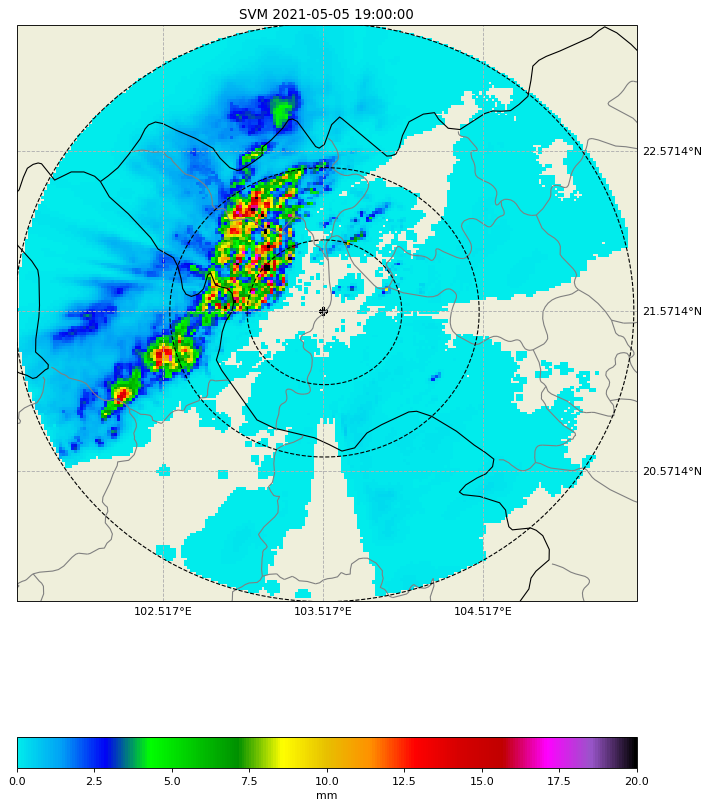

In [72]:
# Draw Range_Rings
circle_points_50km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=50000, n_samples=180, endpoint=False)
circle_points_100km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=100000, n_samples=180, endpoint=False)
circle_points_200km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=200000, n_samples=180, endpoint=False)
geom_50km=Polygon(circle_points_50km)
geom_100km=Polygon(circle_points_100km)
geom_200km=Polygon(circle_points_200km)
# Read file netCDF and prepare datas to plot
fig=plt.figure(figsize=(10,15),dpi=80)
ax1=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_left = False
g1.xlocator = mticker.FixedLocator([102.51694002747536, 103.51694002747536, 104.51694002747536, 105.51694002747536])
g1.ylocator = mticker.FixedLocator([20.571390070021152,21.571390070021152,22.571390070021152])
ax1.set_extent((lon[0],lon[-1],lat[0],lat[-1]),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
#cMap = c.ListedColormap(['b','r'])
z1_plot=ax1.pcolormesh(lons,lats,ma.masked_equal(data2.variables['R_SVM'][1,:,:],0),shading='flat',cmap=pyart.graph.cm.NWSRef,vmax=20, vmin=0)
ax1.scatter(x=103.51694002747536,y=21.571390070021152,transform=ccrs.PlateCarree(), color="black",s=50, alpha=1,marker='P')
ax1.set(title="SVM "+str(date_range[1]) )
plt.colorbar(z1_plot,ax=ax1,orientation='horizontal', label='mm');

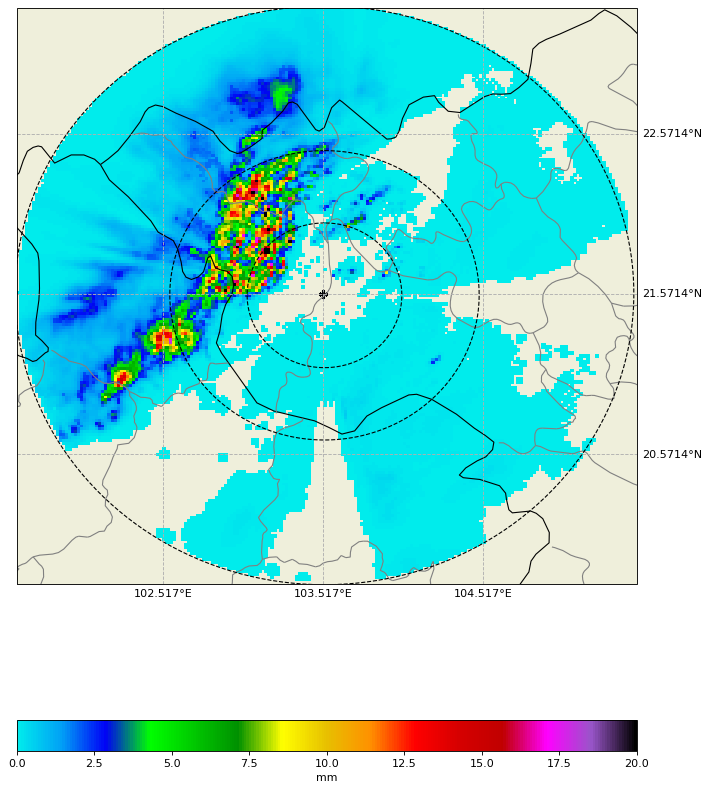

In [73]:
# Read file netCDF and prepare datas to plot
fig=plt.figure(figsize=(10,15),dpi=80)
ax1=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_left = False
g1.xlocator = mticker.FixedLocator([102.51694002747536, 103.51694002747536, 104.51694002747536, 105.51694002747536])
g1.ylocator = mticker.FixedLocator([20.571390070021152,21.571390070021152,22.571390070021152])
ax1.set_extent((lon[0],lon[-1],lat[0],lat[-1]),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
#cMap = c.ListedColormap(['b','r'])
z1_plot=ax1.pcolormesh(lons,lats,ma.masked_equal(data2.variables['R_SHY95'][1,:,:],0),shading='flat',cmap=pyart.graph.cm.NWSRef,vmax=20, vmin=0)
ax1.scatter(x=103.51694002747536,y=21.571390070021152,transform=ccrs.PlateCarree(), color="black",s=50, alpha=1,marker='P')
#ax1.set(title="SVM "+ radar.time['units'][14:])
plt.colorbar(z1_plot,ax=ax1,orientation='horizontal', label='mm');

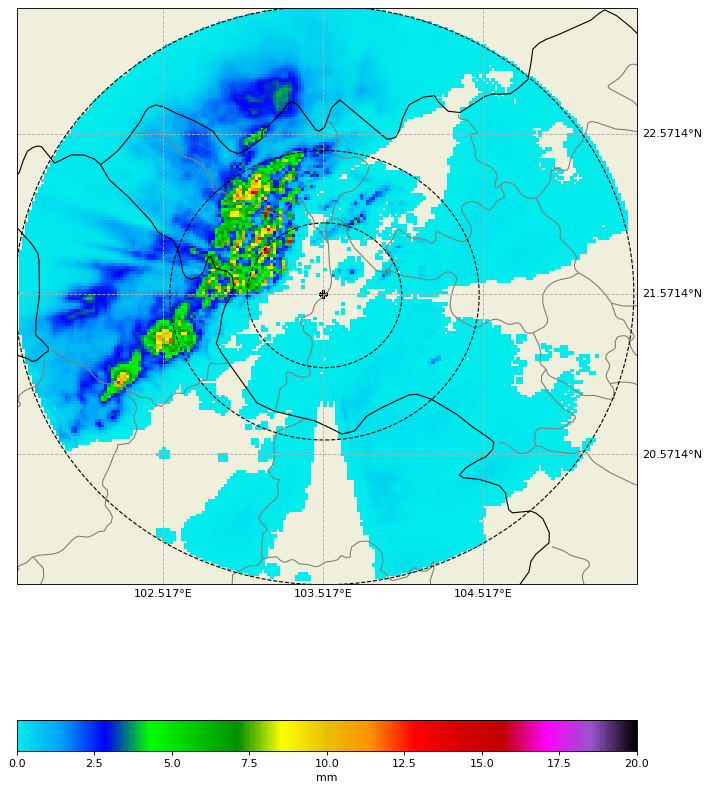

In [74]:
fig=plt.figure(figsize=(10,15),dpi=80)
ax1=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_left = False
g1.xlocator = mticker.FixedLocator([102.51694002747536, 103.51694002747536, 104.51694002747536, 105.51694002747536])
g1.ylocator = mticker.FixedLocator([20.571390070021152,21.571390070021152,22.571390070021152])
ax1.set_extent((lon[0],lon[-1],lat[0],lat[-1]),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
#cMap = c.ListedColormap(['b','r'])
z1_plot=ax1.pcolormesh(lons,lats,ma.masked_equal(data2.variables['R_Marshall'][1,:,:],0),shading='flat',cmap=pyart.graph.cm.NWSRef,vmax=20, vmin=0)
ax1.scatter(x=103.51694002747536,y=21.571390070021152,transform=ccrs.PlateCarree(), color="black",s=50, alpha=1,marker='P')
#ax1.set(title="SVM "+ radar.time['units'][14:])
plt.colorbar(z1_plot,ax=ax1,orientation='horizontal', label='mm');

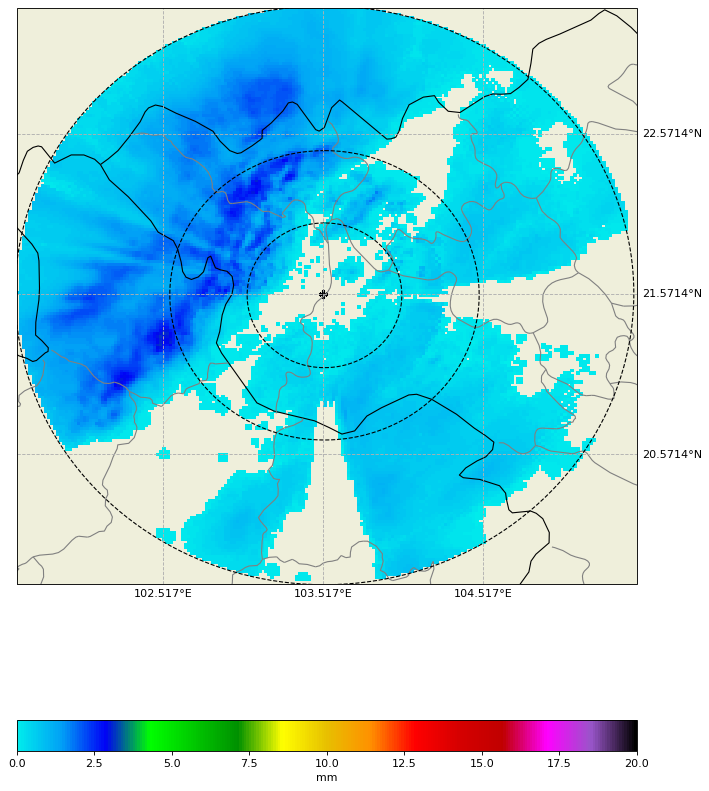

In [75]:
fig=plt.figure(figsize=(10,15),dpi=80)
ax1=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_left = False
g1.xlocator = mticker.FixedLocator([102.51694002747536, 103.51694002747536, 104.51694002747536, 105.51694002747536])
g1.ylocator = mticker.FixedLocator([20.571390070021152,21.571390070021152,22.571390070021152])
ax1.set_extent((lon[0],lon[-1],lat[0],lat[-1]),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
#cMap = c.ListedColormap(['b','r'])
z1_plot=ax1.pcolormesh(lons,lats,ma.masked_equal(data2.variables['R_NHĐ'][1,:,:],0),shading='flat',cmap=pyart.graph.cm.NWSRef, vmax=20, vmin=0)
ax1.scatter(x=103.51694002747536,y=21.571390070021152,transform=ccrs.PlateCarree(), color="black",s=50, alpha=1,marker='P')
#ax1.set(title="SVM "+ radar.time['units'][14:])
plt.colorbar(z1_plot,ax=ax1,orientation='horizontal', label='mm');